In [20]:
import numpy as np
import cv2
import os
import time
from datetime import datetime
import matplotlib.pyplot as plt

print("OpenCV:", cv2.__version__)

OpenCV: 4.4.0


In [33]:
url = 0 # La webcam propia
url = "http://24.103.196.243/cgi-bin/viewer/video.jpg" # una calle
url = "http://12.216.61.98:82/mjpg/video.mjpg" # Perretes
url = "http://46.84.170.81/videostream.cgi?user=admin&pwd=" # Vacas
url = "http://207.199.201.177/mjpg/video.mjpg" # Caballo
#url = "http://77.243.103.105:8081/mjpg/video.mjpg" # Tienda
url = "http://12.216.61.98:82/mjpg/video.mjpg" # Perretes


# Comprobar camara

In [34]:
cap = cv2.VideoCapture(url)

while(True):
    ret, frame = cap.read()

    cv2.imshow('frame', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Manual Substraction (of 1st frame)

In [4]:
cap = cv2.VideoCapture(url)

ok, first_frame = cap.read()

while(1):
    ok, frame = cap.read()
    diff = cv2.absdiff(first_frame, frame)

    cv2.imshow('first_frame',first_frame)
    cv2.imshow('frame', frame)
    cv2.imshow('diff', diff)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Obtener fondo por la Media
As long as a pixel is not covered by a moving object more than 50% of the time, the median of the pixel will give a good estimate of the background at that pixel.

In [32]:
# Open Video
cap = cv2.VideoCapture(url)

# Store selected frames in an array
frames = []
bg = None

count = 10
while(True):
    ret, frame = cap.read()
    frames.append(frame)

    # Calculate the median along the time axis
    if count==10:
        bg = np.median(frames, axis=0).astype(dtype=np.uint8)
        count=0
        print("actualizo")
    count+=1
    
    cv2.imshow('frame', frame)
    cv2.imshow('median', bg)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

actualizo
actualizo
actualizo
actualizo
actualizo


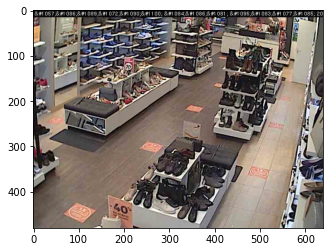

In [27]:
plt.imshow(bg[:,:,::-1])

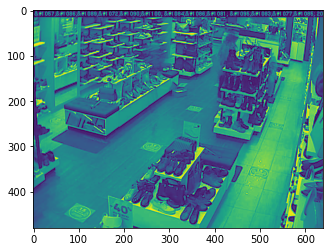

In [14]:
bg_grey = cv2.cvtColor(bg, cv2.COLOR_BGR2GRAY)
plt.imshow(bg_grey)

In [29]:
cap = cv2.VideoCapture(url)
 
while(True):
    ok, frame = cap.read()
    
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    diff = cv2.absdiff(bg_grey, frame_gray)
    
    ret,mask = cv2.threshold(diff,20,255,cv2.THRESH_BINARY)
    fg = cv2.bitwise_and(frame,frame,mask = mask)
    

    cv2.imshow('medianFrame', bg_grey)
    cv2.imshow('frame', frame_gray)
    cv2.imshow('diff', diff)
    cv2.imshow('mask', fg)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# By running mean

In [4]:
c = cv2.VideoCapture(url)
_,f = c.read()

avg1 = np.float32(f)
avg2 = np.float32(f)

while(1):
    _,f = c.read()

    cv2.accumulateWeighted(f,avg1,0.1)
    cv2.accumulateWeighted(f,avg2,0.01)

    res1 = cv2.convertScaleAbs(avg1)
    res2 = cv2.convertScaleAbs(avg2)

    cv2.imshow('img',f)
    cv2.imshow('avg1',res1)
    cv2.imshow('avg2',res2)

    if cv2.waitKey(0):
        break

cv2.destroyAllWindows()
c.release()

# BackgroundSubtractorMOG2

In [25]:
cap = cv2.VideoCapture(url)

#fgbg = cv2.createBackgroundSubtractorMOG2(history=20, varThreshold=25, detectShadows=True)
fgbg = cv2.createBackgroundSubtractorMOG2(history=20, varThreshold=25, detectShadows=True)

while(1):
    ret, frame = cap.read()

    fgmask = fgbg.apply(frame)
    bgmask = cv2.bitwise_not(fgmask)
    
    fg = cv2.bitwise_and(frame,frame,mask = fgmask)
    bg = cv2.bitwise_and(frame,frame,mask = bgmask)

    cv2.imshow('foregroug',fg)
    cv2.imshow('backgroug',bg)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()